In [38]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np


In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import librosa.display

# Set the parent directory for speaker folders
parent_dir = "./archive/16000_pcm_speeches/audio"

# List of speaker folders
speaker_folders = [
    "Abhishek",
    "Anirban",
    "Arunanshu",
    "Shivam",
    "Sunamdha"
]

def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=48000, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=90)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# Encode labels with explicit classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_ = np.array(speaker_folders)

# Split the data into training, validation, and test sets
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_test.shape)

Training Data Shape: (1115, 94, 90)
Validation Data Shape: (479, 94, 90)


Epoch 1/20
18/18 [==============================] - 8s 221ms/step - loss: 1.7699 - accuracy: 0.2592 - val_loss: 1.5173 - val_accuracy: 0.4614
Epoch 2/20
18/18 [==============================] - 3s 162ms/step - loss: 1.3292 - accuracy: 0.5300 - val_loss: 1.2007 - val_accuracy: 0.5783
Epoch 3/20
18/18 [==============================] - 3s 161ms/step - loss: 1.0334 - accuracy: 0.6422 - val_loss: 0.9627 - val_accuracy: 0.6639
Epoch 4/20
18/18 [==============================] - 3s 159ms/step - loss: 0.7432 - accuracy: 0.8099 - val_loss: 0.8054 - val_accuracy: 0.7140
Epoch 5/20
18/18 [==============================] - 3s 171ms/step - loss: 0.5050 - accuracy: 0.8780 - val_loss: 1.1313 - val_accuracy: 0.7683
Epoch 6/20
18/18 [==============================] - 3s 160ms/step - loss: 0.6088 - accuracy: 0.8610 - val_loss: 0.4176 - val_accuracy: 0.9019
Epoch 7/20
18/18 [==============================] - 3s 171ms/step - loss: 0.3484 - accuracy: 0.9570 - val_loss: 0.2034 - val_accuracy: 0.9958
Epoch 

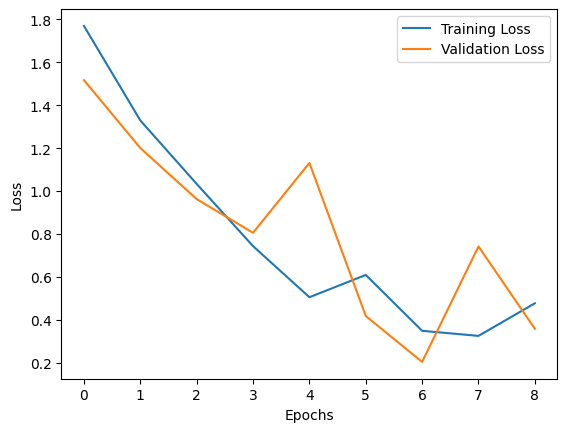

In [26]:
from tensorflow.keras.regularizers import l2
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    #tf.keras.layers.Dropout(0.2),  # Adding dropout for regularization
    tf.keras.layers.LSTM(128),
    #tf.keras.layers.LSTM(128),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, callbacks=[early_stopping])

# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

15/15 [==============================] - 1s 36ms/step
Test Evaluation Accuracy: 0.9958246346555324
Weighted F1 Score: 0.9958246346555324


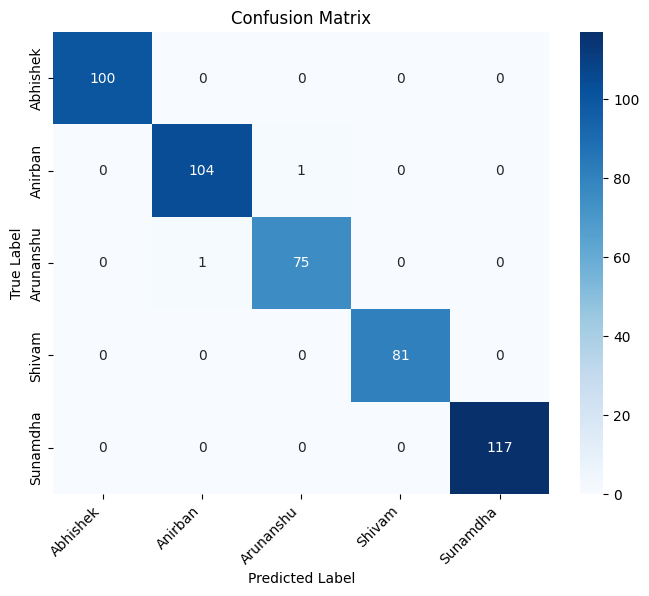

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Testing**

In [28]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Set the parent directory for speaker folders
parent_dir = "./archive/Article/16000_pcm_speeches/audio"

# List of speaker folders
speaker_folders = [
    "Abhishek",
    "Anirban",
    "Arunanshu",
    "Shivam",
    "Sunamdha"
]

def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=48000, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=90)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

In [29]:
print(X.shape)

(1594, 94, 90)


In [30]:
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.preprocessing import LabelEncoder

# # Encode labels with explicit classes
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# label_encoder.classes_ = np.array(speaker_folders)

# # Split the data into training, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Print the shapes of training and validation data
# print("Training Data Shape:", X_train.shape)
# print("Validation Data Shape:", X_val.shape)

50/50 [==============================] - 2s 33ms/step
Test Evaluation Accuracy: 0.9918444165621079
Weighted F1 Score: 0.9918454749409912


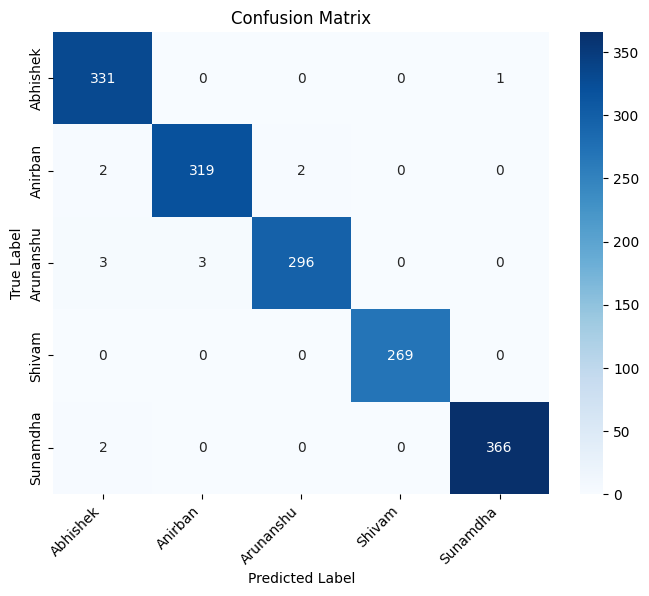

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

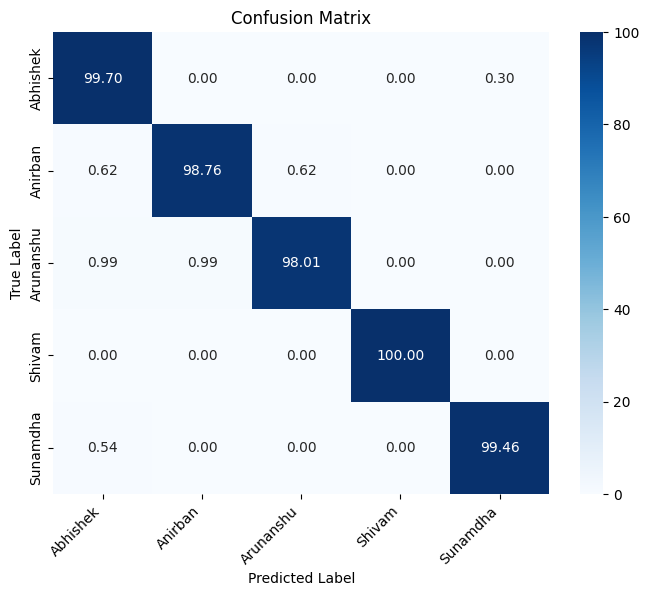

In [32]:
# Convert confusion matrix to percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()